In [1]:

#Checking the installed Java version
!java -version
!pip install pyspark 
# Install Java 17
!sudo apt-get update
!sudo apt-get install -y openjdk-17-jdk-headless

!java -version


openjdk version "17.0.14-internal" 2025-01-21
OpenJDK Runtime Environment (build 17.0.14-internal+0-adhoc..src)
OpenJDK 64-Bit Server VM (build 17.0.14-internal+0-adhoc..src, mixed mode, sharing)
Hit:1 https://packages.cloud.google.com/apt cloud-sdk InRelease
Hit:2 https://cli.github.com/packages stable InRelease                         
Hit:3 https://nvidia.github.io/libnvidia-container/stable/deb/amd64  InRelease 
Hit:4 https://download.docker.com/linux/ubuntu noble InRelease                 
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64  InRelease
Hit:6 https://archive.ubuntu.com/ubuntu noble InRelease                        
Hit:7 https://archive.ubuntu.com/ubuntu noble-updates InRelease                
Hit:8 https://us-east-1.ec2.archive.ubuntu.com/ubuntu noble InRelease          
Hit:9 https://archive.ubuntu.com/ubuntu noble-backports InRelease              
Hit:10 https://us-east-1.ec2.archive.ubuntu.com/ubuntu noble-updates InRelease 
Hit:11 h

In [ ]:
#!conda install -y -c conda-forge openjdk=17


In [3]:
# Set JAVA_HOME to Java 17
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

In [4]:
#!pip install sparksql-magic plotly pandas "nbformat>=4.2.0"

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName("ML_project") \
        .getOrCreate()
print("Spark ready:", spark.version)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/12 23:06:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark ready: 3.5.0


In [6]:
#!pip install sparksql-magic plotly pandas "nbformat>=4.2.0"

In [7]:
#!pip install matplotlib scikit-learn seaborn

In [8]:
#!pip install pyarrow

In [19]:
# Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import roc_curve, auc

# PySpark SQL
from pyspark.sql import functions as F
from pyspark.sql import types as tp
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import *
from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, ArrayType, IntegerType, NumericType
)

# PySpark ML - statistics
from pyspark.ml.stat import Correlation

# PySpark ML - feature engineering
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, UnivariateFeatureSelector
)

# PySpark ML - models
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

# PySpark ML - evaluation, tuning, pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline


In [10]:
file_path = "/teamspace/studios/this_studio/loan_data.csv"
csv_schema = "person_age DOUBLE, person_gender STRING, person_education STRING, person_income DOUBLE, person_emp_exp INTEGER, person_home_ownership STRING, loan_amnt DOUBLE, loan_intent STRING, loan_int_rate DOUBLE, loan_percent_income DOUBLE, cb_person_cred_hist_length DOUBLE, credit_score DOUBLE, previous_loan_dfaults_on_file STRING, loan_status INTEGER"
# Import data
df = (spark.read
      .option("header", "true")
      .option("multiLine", "true")
      .option("quote", "\"")
      .option("escape", "\"")
      .option("unescapedQuoteHandling", "BACK_TO_DELIMITER")
      .schema(csv_schema)
      .csv(file_path))

## RDD

In [11]:
df = df.repartition(8)
print("\nThe number of partitions are :" + str(df.rdd.getNumPartitions()) + "\n")

25/12/12 23:06:51 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: person_age, person_gender, person_education, person_income, person_emp_exp, person_home_ownership, loan_amnt, loan_intent, loan_int_rate, loan_percent_income, cb_person_cred_hist_length, credit_score, previous_loan_defaults_on_file, loan_status
 Schema: person_age, person_gender, person_education, person_income, person_emp_exp, person_home_ownership, loan_amnt, loan_intent, loan_int_rate, loan_percent_income, cb_person_cred_hist_length, credit_score, previous_loan_dfaults_on_file, loan_status
Expected: previous_loan_dfaults_on_file but found: previous_loan_defaults_on_file
CSV file: file:///teamspace/studios/this_studio/loan_data.csv



The number of partitions are :8



In [12]:
df.cache()

DataFrame[person_age: double, person_gender: string, person_education: string, person_income: double, person_emp_exp: int, person_home_ownership: string, loan_amnt: double, loan_intent: string, loan_int_rate: double, loan_percent_income: double, cb_person_cred_hist_length: double, credit_score: double, previous_loan_dfaults_on_file: string, loan_status: int]

## Initial Exploration

In [13]:
df.printSchema()

root
 |-- person_age: double (nullable = true)
 |-- person_gender: string (nullable = true)
 |-- person_education: string (nullable = true)
 |-- person_income: double (nullable = true)
 |-- person_emp_exp: integer (nullable = true)
 |-- person_home_ownership: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- loan_intent: string (nullable = true)
 |-- loan_int_rate: double (nullable = true)
 |-- loan_percent_income: double (nullable = true)
 |-- cb_person_cred_hist_length: double (nullable = true)
 |-- credit_score: double (nullable = true)
 |-- previous_loan_dfaults_on_file: string (nullable = true)
 |-- loan_status: integer (nullable = true)



In [14]:
df.dtypes

[('person_age', 'double'),
 ('person_gender', 'string'),
 ('person_education', 'string'),
 ('person_income', 'double'),
 ('person_emp_exp', 'int'),
 ('person_home_ownership', 'string'),
 ('loan_amnt', 'double'),
 ('loan_intent', 'string'),
 ('loan_int_rate', 'double'),
 ('loan_percent_income', 'double'),
 ('cb_person_cred_hist_length', 'double'),
 ('credit_score', 'double'),
 ('previous_loan_dfaults_on_file', 'string'),
 ('loan_status', 'int')]

Missing values

In [20]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

25/12/12 23:08:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: person_age, person_gender, person_education, person_income, person_emp_exp, person_home_ownership, loan_amnt, loan_intent, loan_int_rate, loan_percent_income, cb_person_cred_hist_length, credit_score, previous_loan_defaults_on_file, loan_status
 Schema: person_age, person_gender, person_education, person_income, person_emp_exp, person_home_ownership, loan_amnt, loan_intent, loan_int_rate, loan_percent_income, cb_person_cred_hist_length, credit_score, previous_loan_dfaults_on_file, loan_status
Expected: previous_loan_dfaults_on_file but found: previous_loan_defaults_on_file
CSV file: file:///teamspace/studios/this_studio/loan_data.csv


+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------+-------------------+--------------------------+------------+-----------------------------+-----------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|loan_intent|loan_int_rate|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_dfaults_on_file|loan_status|
+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------+-------------------+--------------------------+------------+-----------------------------+-----------+
|         0|            0|               0|            0|             0|                    0|        0|          0|            0|                  0|                         0|           0|                            0|          0|
+----------+-------------+----------------+-------------+-----------

In [21]:
df.count()

45000

Duplicates

In [22]:
df_no_duplicate = df.dropDuplicates()
df_no_duplicate.count()

45000

In [23]:
cat_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType) and f.name != "loan_status"]


In [24]:
df.select(numeric_cols).describe().show()

25/12/12 23:09:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+--------------------------+-----------------+
|summary|       person_age|    person_income|   person_emp_exp|        loan_amnt|     loan_int_rate|loan_percent_income|cb_person_cred_hist_length|     credit_score|
+-------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+--------------------------+-----------------+
|  count|            45000|            45000|            45000|            45000|             45000|              45000|                     45000|            45000|
|   mean|27.76417777777778|80319.05322222222|5.410333333333333|9583.157555555556|11.006605777777795| 0.1397248888888883|        5.8674888888888885|632.6087555555556|
| stddev|6.045108211348459|80422.49863189524|6.063532086574557|6314.886690541196| 2.978808280225382|0.08721230801404044|         3.879701845161851|50.43586500074228|
|   

In [25]:
df.select(cat_cols).describe().show()

+-------+-------------+----------------+---------------------+-----------------+-----------------------------+
|summary|person_gender|person_education|person_home_ownership|      loan_intent|previous_loan_dfaults_on_file|
+-------+-------------+----------------+---------------------+-----------------+-----------------------------+
|  count|        45000|           45000|                45000|            45000|                        45000|
|   mean|         NULL|            NULL|                 NULL|             NULL|                         NULL|
| stddev|         NULL|            NULL|                 NULL|             NULL|                         NULL|
|    min|       female|       Associate|             MORTGAGE|DEBTCONSOLIDATION|                           No|
|    max|         male|          Master|                 RENT|          VENTURE|                          Yes|
+-------+-------------+----------------+---------------------+-----------------+-----------------------------+



Basic variable manipulation

In [26]:
#converting loan_int_rate to decimal percentage
df = (
    df
    .withColumn("loan_int_rate_percent", F.round(F.col("loan_int_rate") / 100, 3))
    )
df = df.drop("loan_int_rate")

Categorical Values Exploration

In [27]:
for col in cat_cols:
    df.select(col).distinct().show()

+-------------+
|person_gender|
+-------------+
|       female|
|         male|
+-------------+

+----------------+
|person_education|
+----------------+
|     High School|
|       Associate|
|          Master|
|       Doctorate|
|        Bachelor|
+----------------+

+---------------------+
|person_home_ownership|
+---------------------+
|                  OWN|
|                 RENT|
|             MORTGAGE|
|                OTHER|
+---------------------+

+-----------------+
|      loan_intent|
+-----------------+
|DEBTCONSOLIDATION|
|          VENTURE|
|         PERSONAL|
|        EDUCATION|
|  HOMEIMPROVEMENT|
|          MEDICAL|
+-----------------+

+-----------------------------+
|previous_loan_dfaults_on_file|
+-----------------------------+
|                           No|
|                          Yes|
+-----------------------------+



In [28]:
df.groupBy('person_education').agg(count('*').alias('count')).orderBy("count").show()

+----------------+-----+
|person_education|count|
+----------------+-----+
|       Doctorate|  621|
|          Master| 6980|
|     High School|11972|
|       Associate|12028|
|        Bachelor|13399|
+----------------+-----+



In [29]:
df.groupBy('person_education') \
    .agg(
        avg('person_income').alias('avg_income_profession'),
        min('person_income').alias('min_income_profession'),
        max('person_income').alias('max_income_profession')
    ) \
    .orderBy("avg_income_profession", ascending=False) \
    .show()

+----------------+---------------------+---------------------+---------------------+
|person_education|avg_income_profession|min_income_profession|max_income_profession|
+----------------+---------------------+---------------------+---------------------+
|       Doctorate|    87234.54106280193|               9824.0|            1440982.0|
|       Associate|    80641.62362820086|               8000.0|            7200766.0|
|          Master|    80491.92435530086|               8000.0|            1080918.0|
|     High School|    80224.59764450384|               8000.0|            5556399.0|
|        Bachelor|    79703.31972535265|               8000.0|            5545545.0|
+----------------+---------------------+---------------------+---------------------+



In [30]:
df.groupBy('person_home_ownership').agg(count('*').alias('count')).orderBy("count").show()

+---------------------+-----+
|person_home_ownership|count|
+---------------------+-----+
|                OTHER|  117|
|                  OWN| 2951|
|             MORTGAGE|18489|
|                 RENT|23443|
+---------------------+-----+



In [31]:
df.groupBy('loan_intent').agg(count('*').alias('count')).orderBy("count").show()

+-----------------+-----+
|      loan_intent|count|
+-----------------+-----+
|  HOMEIMPROVEMENT| 4783|
|DEBTCONSOLIDATION| 7145|
|         PERSONAL| 7552|
|          VENTURE| 7819|
|          MEDICAL| 8548|
|        EDUCATION| 9153|
+-----------------+-----+



In [32]:
df.groupBy('loan_status').agg(count('*').alias('count')).orderBy("count").show()

+-----------+-----+
|loan_status|count|
+-----------+-----+
|          1|10000|
|          0|35000|
+-----------+-----+



imbalance target 

## Visualizations

In [33]:
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType) and f.name != "loan_status"]

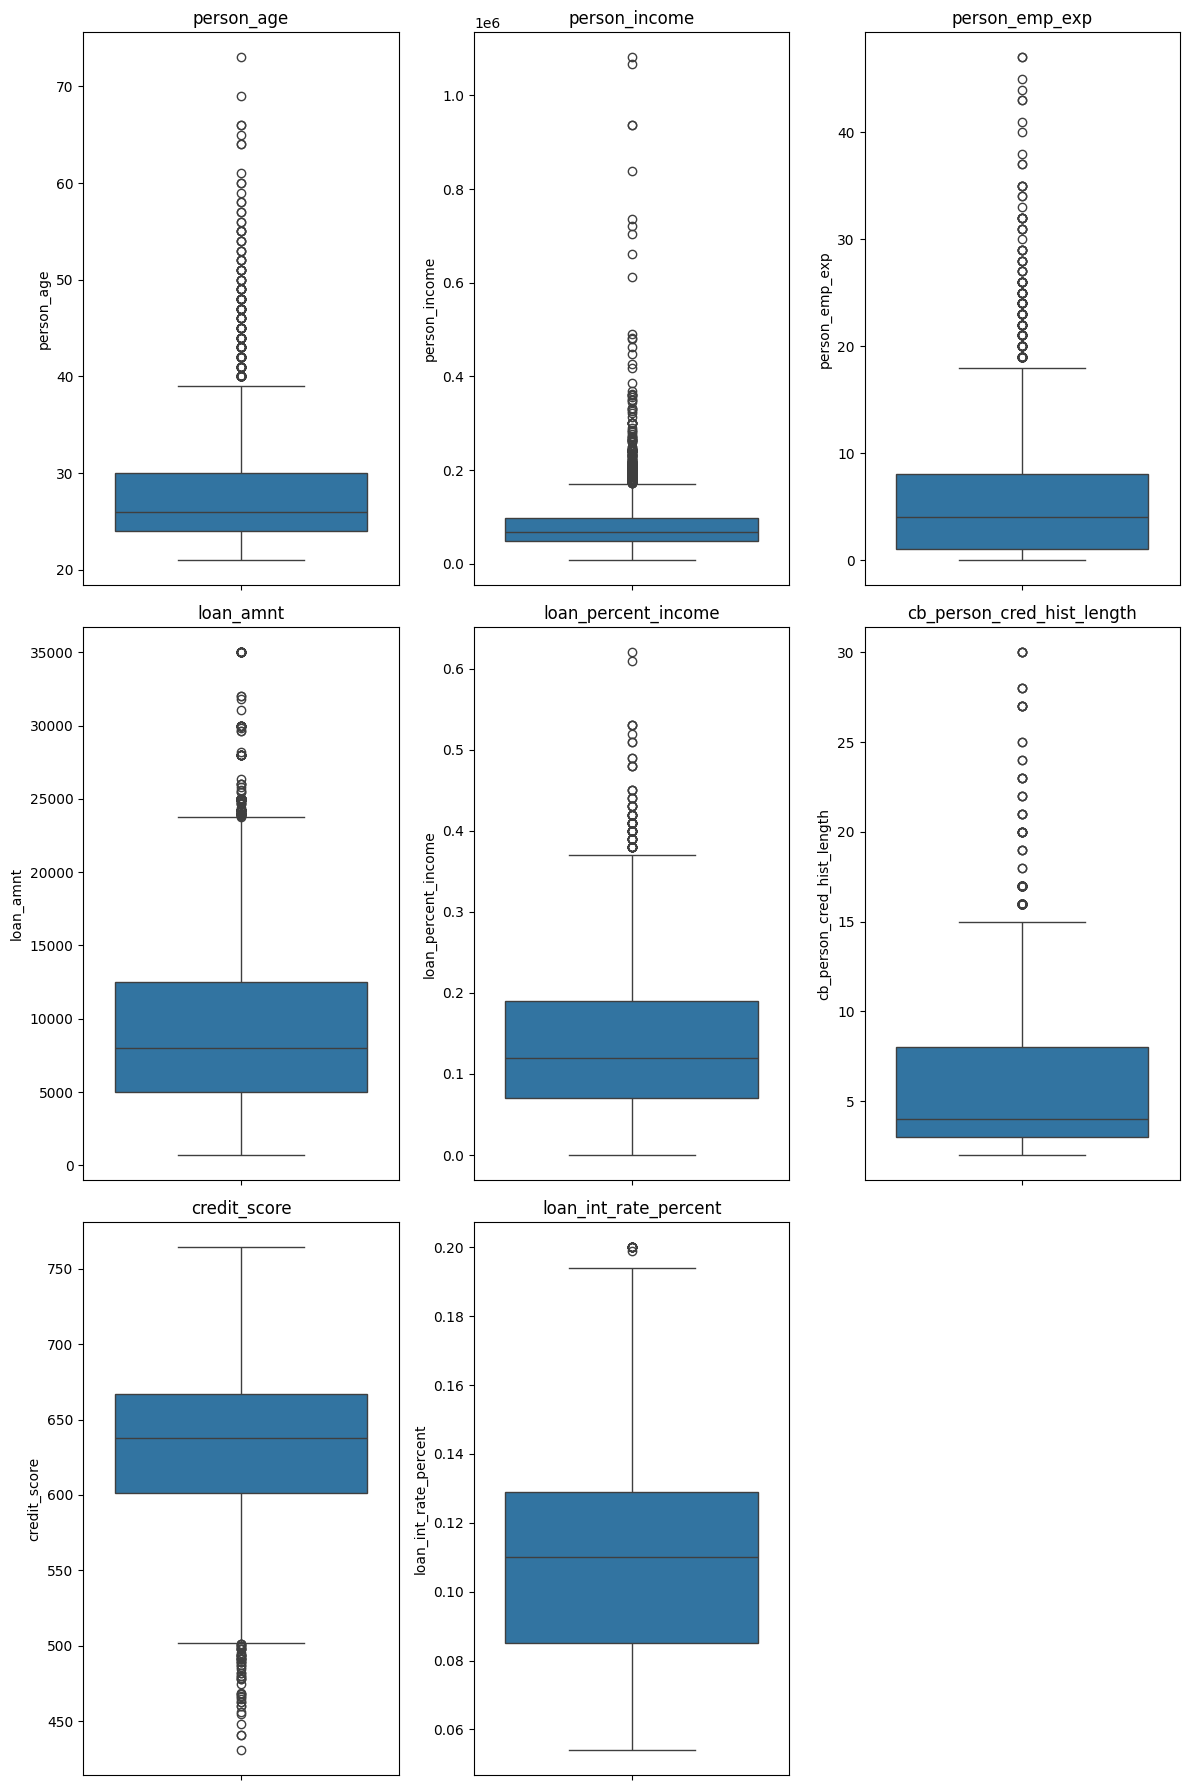

In [34]:
# Sample 10% before converting to Pandas
pdf_num = df.select(numeric_cols).sample(0.1).toPandas()
rows = 3
cols = 3

plt.figure(figsize=(cols * 4, rows * 6))   

for i, col in enumerate(pdf_num.columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=pdf_num[col], orient='v')
    plt.title(col)

plt.tight_layout()
plt.show()

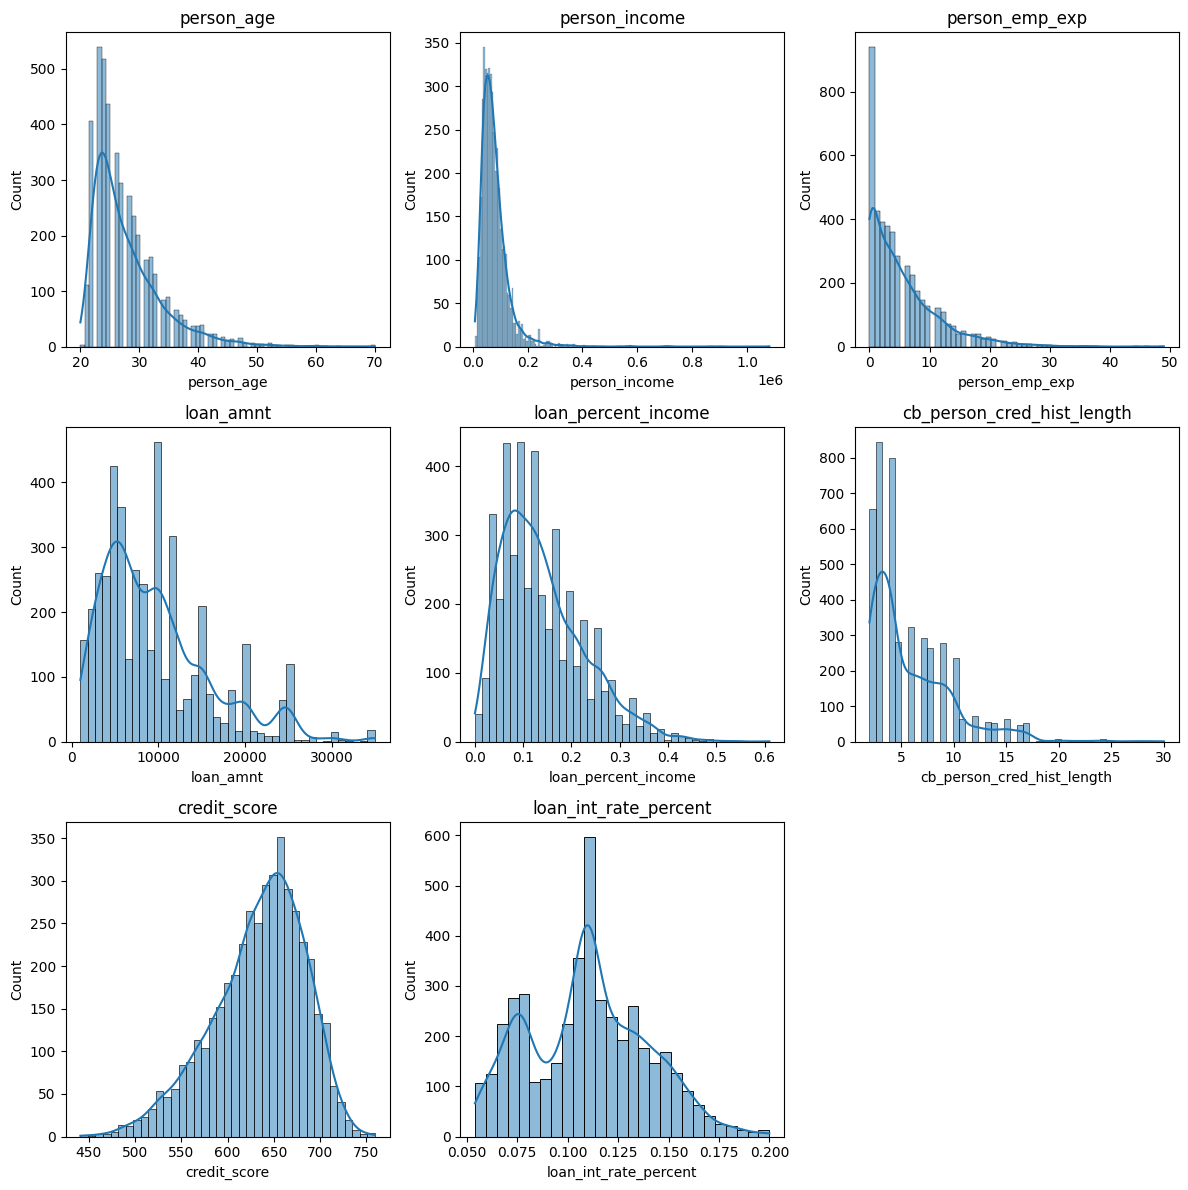

In [35]:
# Sample 10% of numeric data before converting to Pandas
pdf_num = df.select(numeric_cols).sample(0.1).toPandas()
rows = 3
cols = 3

plt.figure(figsize=(cols * 4, rows * 4))

for i, col in enumerate(pdf_num.columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(pdf_num[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

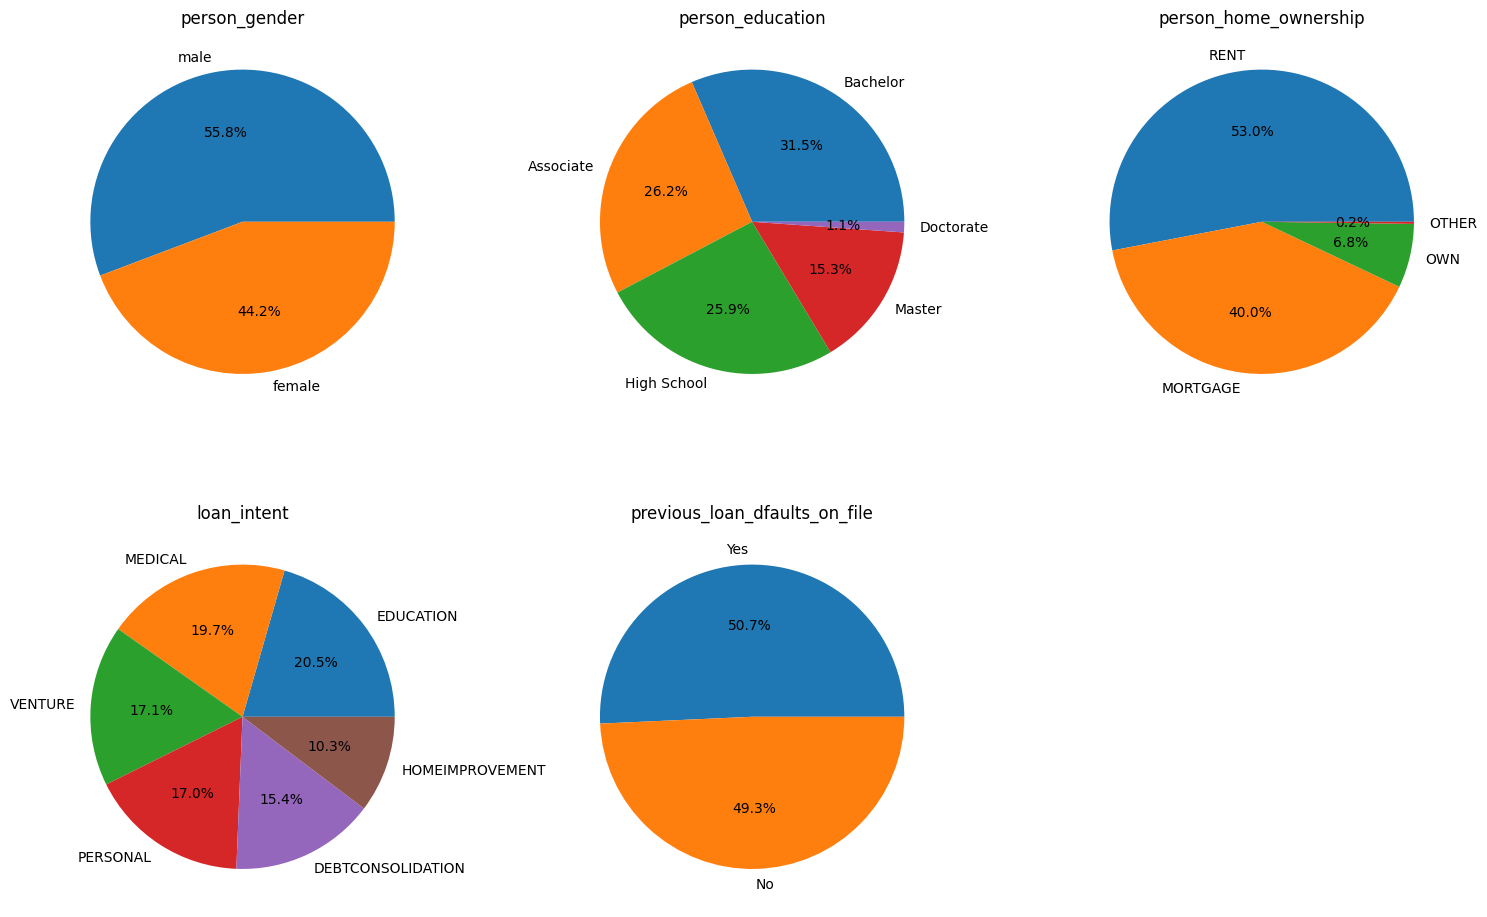

In [36]:
# Sample 10% before converting to Pandas
pdf_cat = df.select(cat_cols).sample(0.1).toPandas()

rows = 3   
cols = 3

plt.figure(figsize=(cols * 5, rows * 5))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(rows, cols, i)
    pdf_cat[col].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(col)
    plt.ylabel("")   

plt.tight_layout()
plt.show()


## Inconsistencies

1. Person older than 120

In [37]:
df.filter("person_age>120").show()

+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|loan_intent|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_dfaults_on_file|loan_status|loan_int_rate_percent|
+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+
|     144.0|         male|        Bachelor|     300616.0|           125|                 RENT|   4800.0|    VENTURE|               0.02|                       3.0|       789.0|                           No|          0|                0.136|
|     144.0|         male|       Ass

2. Having year of experience higher than 60 because the person's age of retirement is 70

In [38]:
df.filter("person_emp_exp>60").show()

+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|loan_intent|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_dfaults_on_file|loan_status|loan_int_rate_percent|
+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+
|      80.0|         male|     High School|      77894.0|            62|                 RENT|   6800.0|    MEDICAL|               0.09|                      25.0|       673.0|                           No|          0|                0.117|
|     144.0|         male|        Ba

3. Percent of loan amount of annual income to be 0 

In [39]:
df.filter("loan_percent_income = 0").show()

+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|      loan_intent|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_dfaults_on_file|loan_status|loan_int_rate_percent|
+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+
|      30.0|       female|       Associate|     627222.0|             4|             MORTGAGE|   2500.0|  HOMEIMPROVEMENT|                0.0|                       9.0|       637.0|                           No|          0|                0.074|
|      43.0|

In [40]:
inc = (df.person_age > 120) | (df.person_emp_exp > 60) | (df.loan_percent_income == 0)
inc_df = df.filter(inc)

In [41]:
total_count = df.count()
rows_to_remove = inc_df.count()
percent_removed = (rows_to_remove/total_count)* 100
print(f"We remove {percent_removed:.2f}% of the data")

We remove 0.08% of the data


## Preprocessing

Dealing with inconsistencies 

In [42]:
df_new = df.filter(~inc)
df_new.filter(inc).show()

+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|loan_intent|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_dfaults_on_file|loan_status|loan_int_rate_percent|
+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+
+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+



Outliers

In [43]:
numeric_cols = [f.name for f in df_new.schema.fields if isinstance(f.dataType, NumericType) and f.name != "loan_status"]
distribution_df = df_new.select(*numeric_cols).summary(
"mean",
"stddev",
"min",
"1%",
"5%",
"50%",
"95%",
"99%",
"max",    
)
distribution_df.show()

+-------+------------------+-----------------+-----------------+-----------------+-------------------+--------------------------+------------------+---------------------+
|summary|        person_age|    person_income|   person_emp_exp|        loan_amnt|loan_percent_income|cb_person_cred_hist_length|      credit_score|loan_int_rate_percent|
+-------+------------------+-----------------+-----------------+-----------------+-------------------+--------------------------+------------------+---------------------+
|   mean|27.738091002090467|79391.94809411555|5.384201396610773|9586.415513943868|0.13981141306765055|         5.861828937419384| 632.5828848463283|   0.1100893341635914|
| stddev|5.8812302343964795|57431.29155795884|5.897008000842123|6314.978622611268|0.08717165214240198|         3.870328219232827|50.388630128409666| 0.029815193459525095|
|    min|              20.0|           8000.0|                0|            500.0|               0.01|                       2.0|             390

Capping

In [44]:
maximum = {
    "person_age": float(distribution_df.select("person_age").collect()[-2].person_age),
    "person_income": float(distribution_df.select("person_income").collect()[-2].person_income),
    "person_emp_exp": float(distribution_df.select("person_emp_exp").collect()[-2].person_emp_exp),
    "loan_amnt": float(distribution_df.select("loan_amnt").collect()[-2].loan_amnt),
    "loan_percent_income": float(distribution_df.select("loan_percent_income").collect()[-2].loan_percent_income),
    "cb_person_cred_hist_length": float(distribution_df.select("cb_person_cred_hist_length").collect()[-2].cb_person_cred_hist_length),
    "credit_score": float(distribution_df.select("credit_score").collect()[-2].credit_score),
    "loan_int_rate_percent": float(distribution_df.select("loan_int_rate_percent").collect()[-2].loan_int_rate_percent),
}
maximum

{'person_age': 48.0,
 'person_income': 270918.0,
 'person_emp_exp': 26.0,
 'loan_amnt': 28250.0,
 'loan_percent_income': 0.4,
 'cb_person_cred_hist_length': 17.0,
 'credit_score': 723.0,
 'loan_int_rate_percent': 0.183}

In [45]:
for k, v in maximum.items():
    df_new = df_new.withColumn(k, F.when(F.col(k) > v, v).otherwise(F.col(k)))
     

## Correlation analysis

25/12/12 23:09:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/12/12 23:09:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


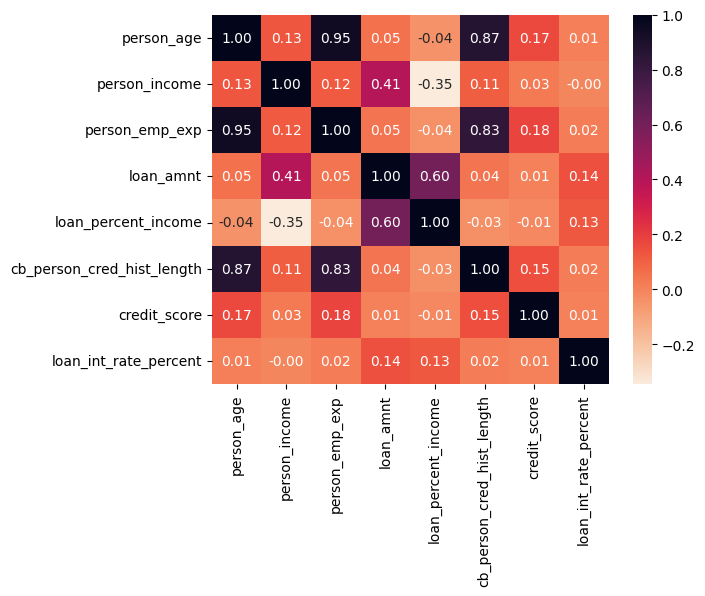

In [ ]:
assembler = VectorAssembler(inputCols=['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_int_rate_percent'], outputCol="features")
df = assembler.transform(df_new).select("features")

pearson_correlation = Correlation.corr(df, "features", "pearson").collect()[0][0]

feature_names = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 
                 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_int_rate_percent']

import seaborn as sns
sns.heatmap(pearson_correlation.toArray(),annot = True, fmt = ".2f",xticklabels=feature_names, 
            yticklabels=feature_names,  cmap = sns.cm.rocket_r)
plt.show()

## Export the preprocessed dataset(run it only once)

In [43]:
#df_new.write.parquet("/teamspace/studios/this_studio/loan_data_processed.parquet", mode="overwrite")

25/12/12 22:08:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


## Feature Preprocessing and Selection (Detailed Analysis)

In [47]:
# get the numerical and categorical columns from the dataframe
column_cat = [f.name for f in df_new.schema.fields if isinstance(f.dataType, StringType)]
column_num = [f.name for f in df_new.schema.fields if isinstance(f.dataType, NumericType) and f.name != "loan_status"]
target = ["loan_status"]

In [48]:
df_fs = df_new

In [49]:
# Convert person_education column to numerical form
df_fs = df_fs.withColumn('education_encoded',
    when(df_fs['person_education'] == 'High School', 0)
    .when(df_fs['person_education'] == 'Bachelor', 1)
    .when(df_fs['person_education'] == 'Associate', 2)
    .when(df_fs['person_education'] == 'Master', 3)
    .when(df_fs['person_education'] == 'Doctorate', 4))

In [50]:
# Convert person_gender column to numerical form
indexer_gender = StringIndexer(inputCol='person_gender', outputCol='GenderIndex')
df_fs = indexer_gender.fit(df_fs).transform(df_fs)

# Convert person_home_ownership column to numerical form
indexer_own = StringIndexer(inputCol='person_home_ownership', outputCol='OwndershipIndex')
df_fs = indexer_own.fit(df_fs).transform(df_fs)

# Convert loan_intent column to numerical form
indexer_loanint = StringIndexer(inputCol='loan_intent', outputCol='LoanIntentIndex')
df_fs = indexer_loanint.fit(df_fs).transform(df_fs)

# Convert previous_loan_dfaults_on_file column to numerical form
indexer_prev_loan = StringIndexer(inputCol='previous_loan_dfaults_on_file', outputCol='PrevLoanIndex')
df_fs = indexer_prev_loan.fit(df_fs).transform(df_fs)

encoder = OneHotEncoder(inputCols=[ 'education_encoded', 'OwndershipIndex', 'LoanIntentIndex'], 
                                 outputCols=['EducVec','OwndershipVec', 'LoanIntentVec'])
model = encoder.fit(df_fs)
df_fs = model.transform(df_fs)


In [51]:
# Assemble categorical features into vector
assembler_cat = VectorAssembler(inputCols=['EducVec', 'OwndershipVec', 'LoanIntentVec', 'GenderIndex', 'PrevLoanIndex'], outputCol='features_cat')
df_fs = assembler_cat.transform(df_fs)

In [52]:
# Assemble numerical features into vector
assembler_num = VectorAssembler(inputCols=column_num, outputCol='features_num')
df_fs = assembler_num.transform(df_fs)

In [53]:
#Get the features
original_feat_num = assembler_num.getInputCols() 

In [54]:
df_fs.show()

+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+-----------------+-----------+---------------+---------------+-------------+-------------+-------------+-------------+--------------------+--------------------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|      loan_intent|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_dfaults_on_file|loan_status|loan_int_rate_percent|education_encoded|GenderIndex|OwndershipIndex|LoanIntentIndex|PrevLoanIndex|      EducVec|OwndershipVec|LoanIntentVec|        features_cat|        features_num|
+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------------+-------------------+--------------------------+------------+----

In [55]:
def stratified_split(df, train_ratio=0.8, target_col='loan_status', seed=42):
    # Split by class
    pos = df.filter(F.col(target_col) == 1)
    neg = df.filter(F.col(target_col) == 0)
    
    # Random split each class
    train_pos, test_pos = pos.randomSplit([train_ratio, 1-train_ratio], seed=seed)
    train_neg, test_neg = neg.randomSplit([train_ratio, 1-train_ratio], seed=seed)
    
    # Union results
    train_df = train_pos.union(train_neg)
    test_df = test_pos.union(test_neg)
    
    return train_df, test_df


In [56]:
train_df, test_df = stratified_split(df_fs, train_ratio=0.8, target_col='loan_status')

In [57]:
# Create selector
selector_cat = UnivariateFeatureSelector(
    featuresCol="features_cat",
    outputCol="selectedFeatures_cat",
    labelCol="loan_status",
    selectionMode="numTopFeatures"
)
selector_cat.setFeatureType("categorical")
selector_cat.setLabelType("categorical")
selector_cat.setSelectionThreshold(9)

# Featrue selection on the training set
model_cat = selector_cat.fit(train_df)
train_fs = model_cat.transform(train_df)
test_fs = model_cat.transform(test_df)


In [58]:
# Check the size of each vector column
sample_row = train_df.select('EducVec', 'OwndershipVec', 'LoanIntentVec').first()

educ_size = len(sample_row.EducVec)
ownership_size = len(sample_row.OwndershipVec)
loan_intent_size = len(sample_row.LoanIntentVec)

print(f"EducVec size: {educ_size}")
print(f"OwndershipVec size: {ownership_size}")
print(f"LoanIntentVec size: {loan_intent_size}")


EducVec size: 4
OwndershipVec size: 3
LoanIntentVec size: 5


In [59]:
selected_indices_cat = model_cat.selectedFeatures
print(selected_indices_cat) 

[4, 5, 6, 7, 8, 9, 11, 13, 10]


Categorical Feature Selected

EducVec: 4 elements → indices 0, 1, 2, 3

OwndershipVec: 3 elements → indices 4, 5, 6 

LoanIntentVec: 5 elements → indices 7, 8, 9, 10, 11

GenderIndex: 1 element → index 12

PrevLoanIndex: 1 element → index 13

In [60]:
# Create selector
selector_num = UnivariateFeatureSelector(
    featuresCol="features_num",
    outputCol="selectedFeatures_num",
    labelCol="loan_status",
    selectionMode="numTopFeatures"
)
selector_num.setFeatureType("continuous")
selector_num.setLabelType("categorical")
selector_num.setSelectionThreshold(5)

# Featrue selection on the training set
model_num = selector_num.fit(train_fs)
train_fs = model_num.transform(train_fs)
test_fs = model_num.transform(test_fs)

In [61]:
selected_indices_num = model_num.selectedFeatures
print(selected_indices_num) 

# Map indices to names
selected_num_feature_names = [original_feat_num[i] for i in selected_indices_num]
print(selected_num_feature_names)

[1, 3, 4, 7, 2]
['person_income', 'loan_amnt', 'loan_percent_income', 'loan_int_rate_percent', 'person_emp_exp']


In [62]:
#  Scale continuous features
scaler = StandardScaler(inputCol="selectedFeatures_num", outputCol="scaled_num",
                        withMean=True, withStd=True)
scaler_model = scaler.fit(train_fs)
train_scaled = scaler_model.transform(train_fs)
test_scaled = scaler_model.transform(test_fs)

# Combine scaled continuous with categorical selected features
final_assembler = VectorAssembler(
    inputCols=['selectedFeatures_cat', 'scaled_num'],
    outputCol='features'
)
train_final = final_assembler.transform(train_scaled)
test_final = final_assembler.transform(test_scaled)

In [63]:
train = train_final.select('features', 'loan_status')
test = test_final.select('features', 'loan_status')

In [64]:
train.show()

+--------------------+-----------+
|            features|loan_status|
+--------------------+-----------+
|(14,[2,8,9,10,11,...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,4,8,9,10,1...|          1|
|(14,[0,7,8,9,10,1...|          1|
|(14,[0,8,9,10,11,...|          1|
|(14,[0,3,8,9,10,1...|          1|
|(14,[0,8,9,10,11,...|          1|
|(14,[1,7,8,9,10,1...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,7,8,9,10,1...|          1|
|(14,[1,4,8,9,10,1...|          1|
|(14,[0,8,9,10,11,...|          1|
|(14,[0,7,8,9,10,1...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,6,8,9,10,1...|          1|
|(14,[0,6,8,9,10,1...|          1|
|(14,[1,7,8,9,10,1...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,3,8,9,10,1...|          1|
|(14,[0,4,8,9,10,1...|          1|
+--------------------+-----------+
only showing top 20 rows



In [65]:
test.show()

+--------------------+-----------+
|            features|loan_status|
+--------------------+-----------+
|(14,[0,7,8,9,10,1...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,4,8,9,10,1...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,8,9,10,11,...|          1|
|(14,[0,4,8,9,10,1...|          1|
|(14,[0,4,8,9,10,1...|          1|
|(14,[0,8,9,10,11,...|          1|
|(14,[0,4,8,9,10,1...|          1|
|(14,[0,6,8,9,10,1...|          1|
|(14,[0,3,8,9,10,1...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,7,8,9,10,1...|          1|
|(14,[0,7,8,9,10,1...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,6,8,9,10,1...|          1|
|(14,[1,3,8,9,10,1...|          1|
|(14,[0,5,8,9,10,1...|          1|
|(14,[0,4,8,9,10,1...|          1|
+--------------------+-----------+
only showing top 20 rows



## Logistic Regression

In [66]:
#from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="loan_status")
model = lr.fit(train)
train_pred = model.transform(train)
# Evaluate model performance and get predictions. Make predictions on test set: 
test_preds = model.transform(test)
test_preds.select("loan_status", "prediction", "probability").show(20, truncate=False)

+-----------+----------+------------------------------------------+
|loan_status|prediction|probability                               |
+-----------+----------+------------------------------------------+
|1          |0.0       |[0.5682866978006168,0.4317133021993832]   |
|1          |1.0       |[0.17973600631569647,0.8202639936843035]  |
|1          |1.0       |[0.07547064991865658,0.9245293500813434]  |
|1          |0.0       |[0.7382806352127235,0.26171936478727653]  |
|1          |1.0       |[0.050202301105327744,0.9497976988946722] |
|1          |1.0       |[0.0076320433397354176,0.9923679566602646]|
|1          |1.0       |[0.2401376129185682,0.7598623870814318]   |
|1          |1.0       |[0.14765518994268995,0.8523448100573101]  |
|1          |1.0       |[0.4752819217834546,0.5247180782165455]   |
|1          |1.0       |[0.08730397686229498,0.912696023137705]   |
|1          |0.0       |[0.8413548743967667,0.1586451256032333]   |
|1          |0.0       |[0.5347000206219514,0.46

In [ ]:
training_summary = model.summary

Area under ROC: 0.9512696373638736


In [68]:
evaluator = BinaryClassificationEvaluator(labelCol='loan_status')
train_auc = evaluator.evaluate(train_pred)
test_auc = evaluator.evaluate(test_preds)

print(f"Training AUC: {train_auc}")
print(f"Test AUC: {test_auc}")

Training AUC: 0.9512721149269299
Test AUC: 0.9534228256898774


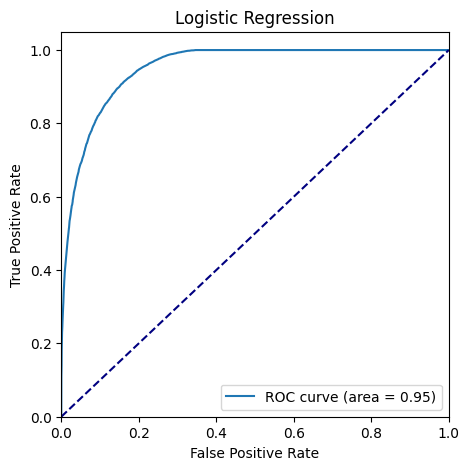

In [69]:
# Print our ROC, this is using pandas, does that make sense?
roc_df = training_summary.roc.toPandas()

plt.figure(figsize=(5,5))
plt.plot(roc_df['FPR'],roc_df['TPR'], label='ROC curve (area = %0.2f)' % training_summary.areaUnderROC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.legend(loc="lower right")
plt.show()

<Figure size 600x600 with 0 Axes>

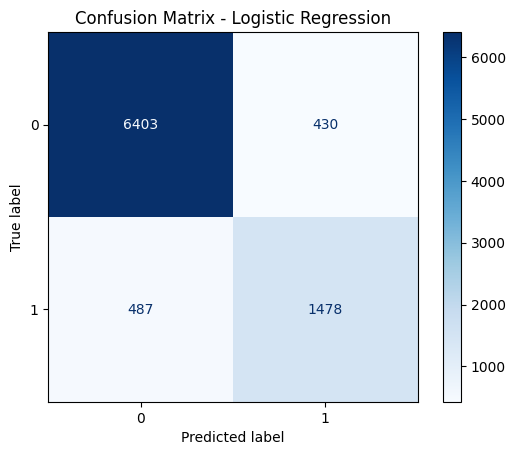

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Collect true labels and predictions
results = test_preds.select("loan_status", "prediction").collect()
y_true = [row['loan_status'] for row in results]
y_pred = [row['prediction'] for row in results]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Random Forest Classifier

In [72]:
# Train Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='loan_status', numTrees=100, maxDepth=5)
rf_model = rf.fit(train)
train_pred = rf_model.transform(train)
test_preds = rf_model.transform(test)

# Evaluate model performance
evaluator = BinaryClassificationEvaluator(labelCol='loan_status')
train_auc = evaluator.evaluate(train_pred)
test_auc = evaluator.evaluate(test_preds)

print(f"Training AUC: {train_auc}")
print(f"Test AUC: {test_auc}")

Training AUC: 0.9586459265792947
Test AUC: 0.9602236787569977


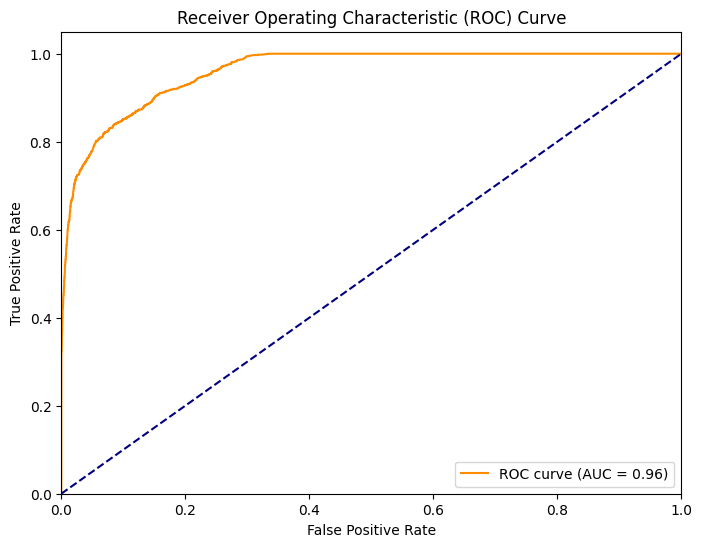

In [73]:
# Get predicted probabilities and labels
predictions = rf_model.transform(test)
results = predictions.select(['probability', 'loan_status']).collect()
probs = [float(i[0][1]) for i in results]
labels = [i[1] for i in results]

# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()